In [1]:
import sys
import warnings

In [2]:
sys.path.append("../../PythonScripts/")
warnings.filterwarnings('ignore')

In [3]:
from prereqs import *

now importing: 
1. numpy as np 
2. matplotlib.pyplot as plt
3. from scipy import stats



In [10]:
from tqdm import tqdm, tqdm_notebook ## for progress bar
## If you *can*, you should use tqdm_notebook instead of tqdm
## See: https://github.com/tqdm/tqdm/issues/375

## be sure to run:  jupyter nbextension enable --py --sys-prefix widgetsnbextension
## then restart notebook

In [ ]:
?tqdm_notebook




## General Metropolis-Hastings 

For a given target density *f* we wish to estimate, we build a Markov kernel *K* with stationary distribution *f* and then generate a Markov chain $X_t$ using this kernel so that the limiting distribution of the Markov chain is *f* and integrals can be approximated according to the *Ergodic Theorem*.

The **Metropolis-Hastings algorithm** is a general purpose MCMC method for approximating a target density *f*, using a conditional density $q(y | x)$ that is easy to simulate from. 

In addition, $q$ can be almost arbitrary in that the only theoretical requirements are that the ratio $\frac{f(y)}{q(y | x)}$ is known up to a constant *independent* of $x$ and that $q( \cdot | x )$ has enough dispertion to lead to an exploration of the entire support of *f*

We can rely on the feature of Metropolis-Hatings algorithm that for every given *q*, we can then construct a Metropolis-Hastings kernel such that *f* is its stationary distribution.


## General Metropolis-Hastings 

The Metropolis-Hastings algorithm as described Robert & Casella goes as follows

Given $x^{(t)}$

`1. Generate` $Y_t \sim q(y | x_t )$

`2. Take`
$$
X_{t+1} = 
  \begin{cases}
    Y_t       & \quad  \text{with probability }\ \rho(x^{(t)}, Y_t) \\
    x^{(t)}   & \quad  \text{with probability }\ 1 - \rho(x^{(t)}, Y_t) \\
  \end{cases}
$$
where 
$$
\displaystyle \rho(x^{(t)}, Y_t) = \text{min} \left\{ \frac{f(Y_t)}{f(x^{(t)})} \frac{q(x^{(t)} | Y_t)}{q(Y_t | x^{(t)})} , 1 \right\}
$$





## General Metropolis-Hastings 

In simpler terms, as we want to generate $X \sim f$, we first take an initial value $x^{(0)}$ (which can almost be any artibrary value in the support of $f$). 

1. We generate a value $Y_0 \sim q(y | x^{(0)})$. 
2. We calculate $\rho(x^{(t)}, Y_t)$
3. Generate a random value $U \sim Unif(0,1)$ 
4. If $U < \rho(x^{(t)}, Y_t)$, then we accept $X^{(1)} = Y_t$;
else we take $X^{(1)} = X^{(0)}$
5. Repeate steps 1-4 until you've satisfied the number of samples needed




## General Metropolis-Hastings 

You may notice the MH algorithm is not too dissimilar from the Accept-Reject algorithm.

`1. Generate` $Y \sim g$, $U \sim Unif(0,1)$

`2. Accept` $X = Y$ `if` $U \leq \frac{f(Y)}{M g(Y)}$ ;

`3. Return to step 1 otherwise`





## Example Beta(2.7, 6.3) 

As of now, we've covered multiple ways of generating random samples from a target density. Let us compare the accept-reject algorithm once more with the Metropolis-Hastings algorithm. Generate $N$ samples from $Beta(2.7, 6.3)$


In order to use the accept-reject algorithm, we need a candidate distribution to sample from. Below are a set of potential candidate distributions.



In [4]:
dbeta = stats.beta.pdf
dexp = stats.expon.pdf
dgamma = stats.gamma.pdf
dnorm = stats.norm.pdf

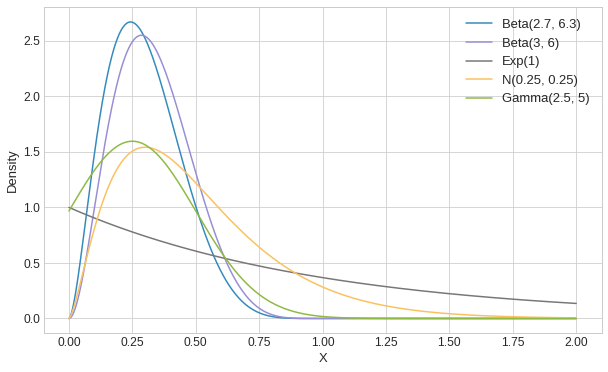

In [5]:
x = np.linspace(start=0, stop = 2, num=1000)
p1 = plot(x, dbeta(x=x, a = 2.7, b = 6.3), ylabel="Density", xlabel="X", color = 1, show=False)
p2 = plot(x, dbeta(x=x, a = 3, b = 6), ylabel="Density", xlabel="X", color = 2, show=False)
p3 = plot(x, dexp(x=x, scale = 1), ylabel="Density", xlabel="X", color = 3, show=False)
p4 = plot(x, dgamma(x=x, a = 2.5, scale = 1/5), ylabel="Density", xlabel="X", color = 4, show=False)
p5 = plot(x, dnorm(x = x, loc = 0.25, scale = 0.25), ylabel="Density", xlabel="X", color = 5, show=False)
plt.legend([p1, p2, p3, p4, p5], 
           ["Beta(2.7, 6.3)", "Beta(3, 6)", "Exp(1)", "N(0.25, 0.25)", "Gamma(2.5, 5)"], 
           fontsize= 13)
plt.show()

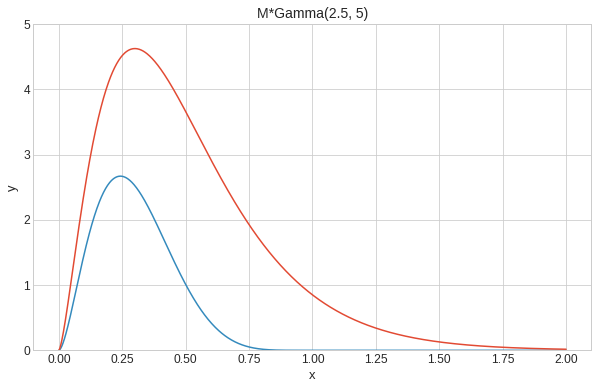

In [6]:
M = 3

plot(x, dbeta(x, a = 2.7, b= 6.3), show = False)
plot(x, M*dgamma(x, a = 2.5, scale = 1/5), title = "M*Gamma(2.5, 5)", color = 0, show=False, ylim=(0, 5))
plt.show()

We will use $Gamma(2.5, 1/5)$ as our candidate distribution, $g$.


In [7]:
N = 100000
## For accept-reject, we need to find a value for M

f = lambda x: dbeta(x, a = 2.7, b = 6.3)
g = lambda x: dgamma(x, a = 2.5, scale = 1/5)

rgamma = np.random.gamma
runif = np.random.rand

In [8]:
#?rgamma ## see this for help
import datetime as dt

In [11]:
progress_bar = tqdm(total=N)

start = dt.datetime.now()
X = []
#N = 200
i = 0
while(i < N):
    Y = rgamma(size = 1, shape = 2.5, scale = 1/5)
    U = runif(1)
    if(U*M <= f(Y)/g(Y)):
        progress_bar.update(1)
        i = i + 1
        X.append(Y)
end = dt.datetime.now()
duration = str(end - start)
print(f"Total time to run: {duration}")

100%|█████████▉| 99859/100000 [00:49<00:00, 2155.67it/s]

Total time to run: 0:00:49.367624


In [12]:
q=[0, 25, 50, 75, 100]
qbeta = stats.beta.ppf ## do not use stats.beta.cdf
print(qbeta(q = [0.0, 0.25, 0.50, 0.75, 1.00], a = 2.7, b = 6.3))

#print(np.percentile(a=X, q=[0, 25, 50, 75, 100]))
summary(X)

## below are results from R:
##         0%        25%        50%        75%       100% 
## 0.00117328 0.18979491 0.28480053 0.39559864 0.94743365

[ 0.          0.18955714  0.28466078  0.39503332  1.        ]
 Min.: [ 0.0034]
 1st Qu.: [ 0.19]
 Median: [ 0.2854]
 3rd Qu.: [ 0.3947]
 Max.: [ 0.882]
 Mean: [ 0.3001]


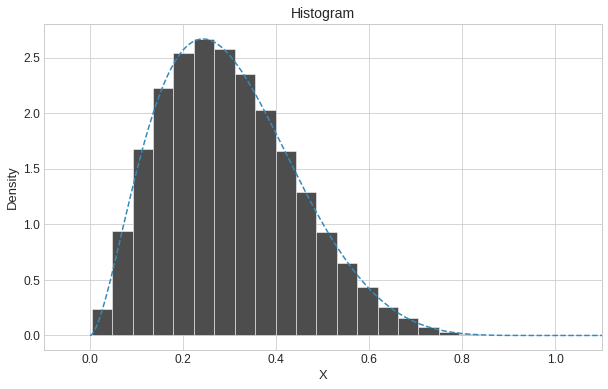

In [13]:
X = np.array(X)
plot(x, dbeta(x, a = 2.7, b= 6.3), show = False, linestyle="--", xlim = (-0.1, 1.1))
hist(X, bins = 20)
#plt.hist(X, bins = 20, normed=True)
#plt.show()

In [14]:
np.percentile(a=  rgamma(size = 100000, shape = 2.5, scale = 1/5), q=[0, 25, 50, 75, 100])

array([  2.88769845e-03,   2.67784318e-01,   4.35880719e-01,
         6.65676241e-01,   2.92531808e+00])

## Example Beta(2.7, 6.3) 

Below is the Metropolis-Hastings implementation for this problem. 

In [15]:
R = []
N = 100000  # try 100 just to test
MH_X = np.zeros(shape=N)
MH_X[0] = 0.123456 ## initial value
for i in tqdm(range(1, N)):
    Y = rgamma(size = 1, shape = 2.5, scale = MH_X[i-1]) # can also use rexp(n = 1, rate = X[i])
    rho = (dbeta(x = Y, a = 2.7, b = 6.3) * dgamma(x = MH_X[i-1], a = 2.5, scale = Y) ) /( dbeta(x = MH_X[i-1], a = 2.7, b = 6.3) * dgamma(x = Y, a = 2.5, scale = MH_X[i-1])  )  
    R.append(rho)
    if(runif(1) < rho):
        MH_X[i] = Y
    else:
        MH_X[i] = MH_X[i-1]



 38%|███▊      | 37625/99999 [00:14<00:23, 2647.87it/s]


 68%|██████▊   | 67773/99999 [00:28<00:13, 2396.53it/s]


100%|██████████| 99999/99999 [00:41<00:00, 2421.99it/s]

In [16]:
summary(np.array(R))

 Min.: [ 0.]
 1st Qu.: [ 0.]
 Median: [ 0.0695]
 3rd Qu.: [ 0.5593]
 Max.: [ 5810.9745]
 Mean: [ 0.7597]


In [17]:
min(R)

array([ 0.])

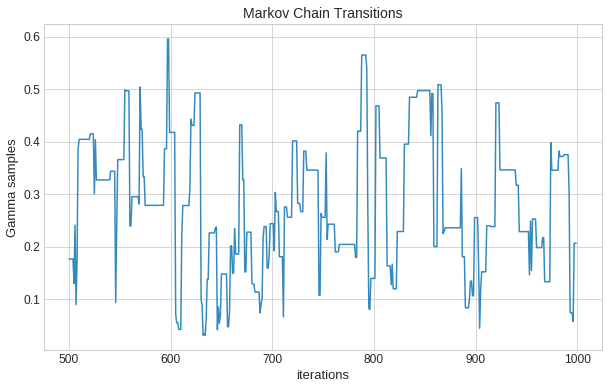

In [18]:
x1 = range(500, 1000)
plot(x1, MH_X[x1], title = "Markov Chain Transitions", ylabel = "Gamma samples", xlabel = "iterations")

In [19]:
print(qbeta(q = [0.0, 0.25, 0.50, 0.75, 1.00], a = 2.7, b = 6.3))

#print(np.percentile(a=X, q=[0, 25, 50, 75, 100]))
summary(MH_X)


[ 0.          0.18955714  0.28466078  0.39503332  1.        ]
 Min.: 0.003
 1st Qu.: 0.1892
 Median: 0.2851
 3rd Qu.: 0.3966
 Max.: 0.9172
 Mean: 0.3015


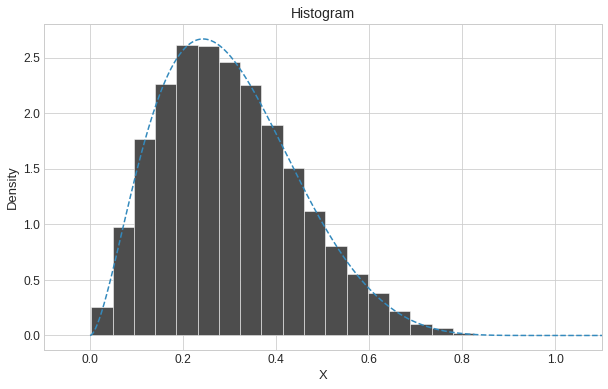

In [20]:
## see how samples from chain compare to Beta(2.7, 6.3) density
plot(x, dbeta(x, a = 2.7, b= 6.3), show = False, linestyle="--", xlim = (-0.1, 1.1))
hist(MH_X, bins = 20)
#plt.hist(X, bins = 20, normed=True)
#plt.show()


## Example Beta(2.7, 6.3) 

Here is a varition of the M-H algorithm used previously, except we do not let the candidate distribution depend on previous values of the chain. The candidate distribution depends only on present values of the chain, in effect $q(y | x) = q(y)$.


In [21]:
X = np.zeros(shape = N)

IndMH_X = np.zeros(shape=N)
IndMH_X[0] = 0.123456 ## random initial value
for i in tqdm(range(1, N)):
    Y = rgamma(size = 1, shape = 2.5, scale = 1/5) # no longer dependent on previous value
    rho = (dbeta(x = Y, a = 2.7, b = 6.3) * dgamma(x = IndMH_X[i-1], a = 2.5, scale = 1/5) ) / ( dbeta(x = IndMH_X[i-1], a = 2.7, b = 6.3) * dgamma(x = Y, a = 2.5, scale = 1/5)  )  
    if(runif(1) < rho):
        IndMH_X[i] = Y
    else:
        IndMH_X[i] = IndMH_X[i-1]


 35%|███▌      | 35330/99999 [00:14<00:25, 2510.79it/s]


 74%|███████▍  | 73813/99999 [00:28<00:09, 2619.97it/s]


100%|██████████| 99999/99999 [00:37<00:00, 2662.71it/s]

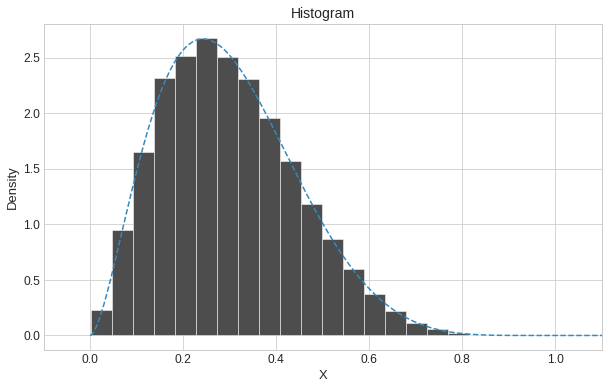

In [22]:
## see how samples from chain compare to Beta(2.7, 6.3) density
plot(x, dbeta(x, a = 2.7, b= 6.3), show = False, linestyle="--", xlim = (-0.1, 1.1))
hist(IndMH_X, bins = 20)
#plt.hist(X, bins = 20, normed=True)
#plt.show()


## Example Beta(2.7, 6.3) 

This version of the M-H algorithm is known as the **Independent Metropolis-Hastings**. This method appears a generalization of the accept-reject algorithm in the sense that the instrumental distribution is the same density $g$ as in the accept-reject algorithm. Thus, the proposed values $Y_i$ are the same, if not the accepted ones.






## Independent M-H 

The **Independent Metropolis-Hastings algorithm** as described Robert & Casella goes as follows

Given $x^{(t)}$

`1. Generate` $Y_t \sim g(y)$

`2. Take`

$$
X_{t+1} = 
  \begin{cases}
    Y_t       & \quad  \text{with probability }\ \rho(x^{(t)}, Y_t) \\
    x^{(t)}   & \quad  \text{with probability }\ 1 - \rho(x^{(t)}, Y_t) \\
  \end{cases}
$$
where 
$$
\displaystyle \rho(x^{(t)}, Y_t) = \text{min} \left\{ \frac{f(Y_t)}{f(x^{(t)})} \frac{g(x^{(t)})}{g(Y_t)}, 1 \right\}
$$




## Independent M-H 

In simpler terms, as we want to generate $X \sim f$, we first take an initial value $x^{(0)}$ (which can almost be any artibrary value in the support of $f$). 

1. We generate a value $Y_0 \sim q(y | x^{(0)})$. 
2. We calculate $\rho(x^{(t)}, Y_t)$
3. Generate a random value $U \sim Unif(0,1)$ 
4. If $U < \rho(x^{(t)}, Y_t)$, then we accept $X^{(1)} = Y_t$;
else we take $X^{(1)} = X^{(0)}$
5. Repeate steps 1-4 until you've satisfied the number of samples needed









## Example: Gamma(4.3, 6.2) 

Here we will compare again the Accept-Reject algorithm against the Metropolis-Hastings. Generate *N* random variables $X \sim Gamma(4.3, 6.2)$.

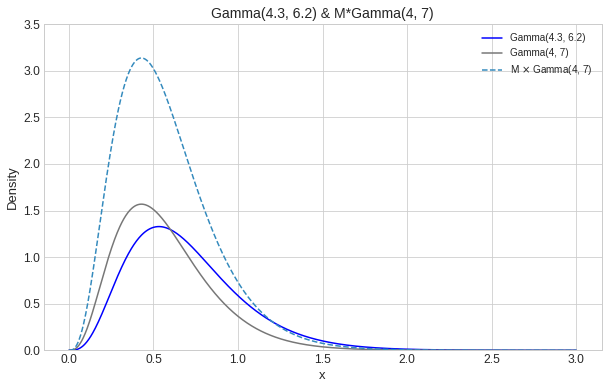

In [23]:
## For accept-reject, we need to find a value for M
## note: Scipy uses scale = 1/rate
M = 2
x = np.linspace(start=0, stop = 3, num=1000)
p1 = plot(x, dgamma(x=x, a = 4.3, scale = 1/6.2), color = "blue", show=False) ## Gamma(4.3, 6.2)
p2 = plot(x, dgamma(x=x, a = 4, scale = 1/7), show = False, color = 3) ## Gamma(4, 7)
p3 = plot(x, M*dgamma(x=x, a = 4, scale = 1/7), title = "Gamma(4.3, 6.2) & M*Gamma(4, 7)", 
     ylim = (0, 3.5), linestyle="--", ylabel = "Density", show=False)
plt.legend([p1, p2, p3], ["Gamma(4.3, 6.2)", "Gamma(4, 7)", r"M $\times$ Gamma(4, 7)"])
plt.show()

In [24]:
f = lambda x: dgamma(x = x, a = 4.3, scale = 1/6.2)
g = lambda x: dgamma(x = x, a = 4, scale = 1/7)

In [25]:
progress_bar = tqdm(total=N)

X = []
i = 0
while(i < N):
    Y = rgamma(size = 1, shape = 4, scale = 1/7)
    U = runif(1)
    if (U*M <= f(Y)/g(Y)):
        progress_bar.update(1)
        i = i + 1
        X.append(Y)



100%|█████████▉| 99763/100000 [00:31<00:00, 2581.91it/s]

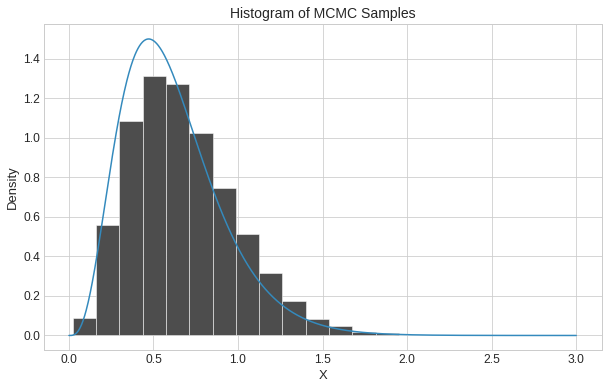

In [26]:
## see how samples from chain compare to Gamma density
X = np.array(X)
plot(x, dgamma(x = x, a =  4.3, scale = 1/7), show=False)
hist(X, bins = 20, title = "Histogram of MCMC Samples", density = True)


## Independent Metropolils Hastings

In [27]:
## Metropolis Hastings 

X = np.zeros(N)
X[0] = rgamma(size = 1, shape = 4.3, scale = 1/6.2)
for i in range(1,N):
    Y = rgamma(size = 1, shape = 4, scale = 1/7)
    rho = (dgamma(x = Y, a = 4.3, scale = 1/6.2) * dgamma(x = X[i-1], a = 4, scale = 1/7)) / (dgamma(x = X[i-1], a = 4.3, scale = 1/6.2) * dgamma(x = Y, a = 4, scale = 1/7)) 
    if (runif(1) < rho):
        X[i] = Y
    else:
        X[i] = X[i-1]

print("finished!")

100%|██████████| 100000/100000 [00:50<00:00, 2581.91it/s]

finished!


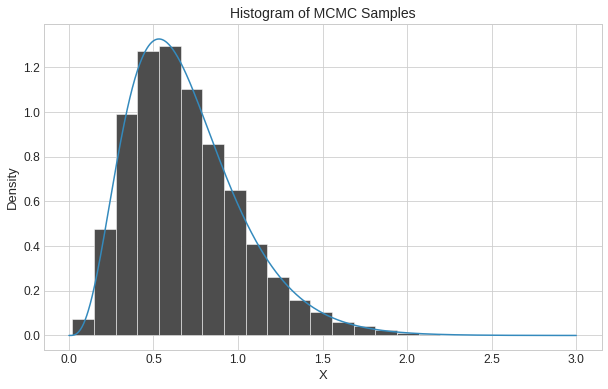

In [28]:
## see how samples from chain compare to Gamma density
plot(x, dgamma(x = x, a =  4.3, scale = 1/6.2), show=False)
hist(X, bins = 20, title = "Histogram of MCMC Samples", density = True)


In [29]:
summary(X)

 Min.: 0.0206
 1st Qu.: 0.4477
 Median: 0.6401
 3rd Qu.: 0.8798
 Max.: 2.5798
 Mean: 0.6923


## Other potential instumential distributions

1. $F_{4, 6}$

2. $Exp(1)$

3. $Gamma(2.5, 5)$



In [30]:
## Exponential
dExp = stats.expon.pdf

## Normal
#dNorm = stats.norm.pdf

## variables for F distribution
dF = stats.f.pdf
rF = np.random.f

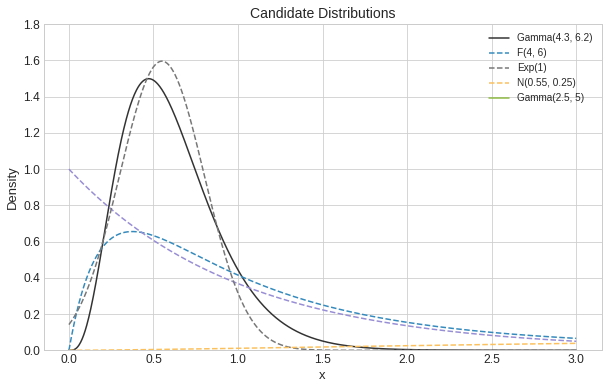

In [31]:
p1 = plot(x, dgamma(x = x, a =  4.3, scale = 1/7), color = '0.2', show=False)
p2 = plot(x, dF(x=x, dfn = 4, dfd = 6), linestyle="--", color=1, show=False)
p3 = plot(x, dExp(x, scale = 1), linestyle = "--", color = 2, show=False)
p3 = plot(x, dnorm(x, loc = 0.55, scale = 0.25) , linestyle = "--", color = 3, show=False)
p4 = plot(x, dgamma(x, a = 2.5, scale = 5) , linestyle = "--", color = 4, show=False, 
          ylim = (0, 1.8), title = "Candidate Distributions", ylabel = "Density")
legend_items = [p1, p2, p3, p4, p5]
plt.legend(legend_items, ["Gamma(4.3, 6.2)", "F(4, 6)", "Exp(1)", "N(0.55, 0.25)", "Gamma(2.5, 5)"])
plt.show()

In [32]:
## Metropolis Hastings
X = np.zeros(N)
X[0] = 0.5
for i in range(1, N):
    Y = rF(size = 1, dfnum = 4, dfden = 6)
    rho = rho = (dgamma(x = Y, a = 4.3, scale = 1/6.2) * dF(x=X[i-1], dfn = 4, dfd = 6)) / (dgamma(x = X[i-1], a = 4.3, scale = 1/6.2) * dF(x=Y, dfn = 4, dfd = 6)) 
    if (runif(1) < rho):
        X[i] = Y
    else:
        X[i] = X[i-1]

In [33]:
summary(X)

 Min.: 0.0228
 1st Qu.: 0.4488
 Median: 0.6395
 3rd Qu.: 0.88
 Max.: 2.7658
 Mean: 0.6938


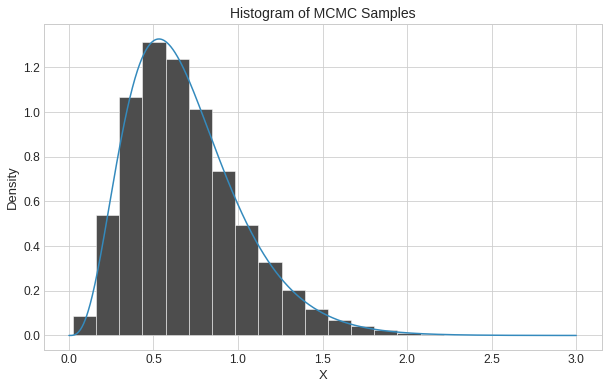

In [34]:
## see how samples from chain compare to Gamma density
plot(x, dgamma(x = x, a =  4.3, scale = 1/6.2), show=False)
hist(X, bins = 20, title = "Histogram of MCMC Samples", density = True)
